In [84]:
import sys
import psi
import numpy as np
import pandas as pd
import torch
import scipy
from sklearn.metrics.cluster import contingency_matrix
import json
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from save_metric import *
from functools import partial
from model_train import compute_prediction
from VAE import *
from torch.optim import Adam, lr_scheduler, RMSprop
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

def build_model(params,in_features):

    hidden_dim = params['hidden_dim']
    hidden_channel = params['hidden_channels']
    latent_dim = params['latent_dim']

    enc = Vae_Encoder(in_features,hidden_dim,latent_dim,hidden_channel)
    dec = Vae_Decoder(in_features,hidden_dim,latent_dim,hidden_channel)
    model = Vae(enc,dec)

    return model

def train_and_evaluate(params,model,dataset_train,dataset_val, num_epoch, batch_size):

    # Dataloader
    train_dataloader = DataLoader(dataset_train,batch_size)
    val_dataloader = DataLoader(dataset_val,batch_size)

    # Betascheduler
    betascheduler_start = params['betascheduler_start']
    betascheduler_stop = params['betascheduler_stop']
    betascheduler_ratio = params['betascheduler_ratio']
    betascheduler_train = Betascheduler(num_epoch,len(train_dataloader), start = betascheduler_start , stop = betascheduler_stop, ratio = betascheduler_ratio )
    betascheduler_val = Betascheduler(num_epoch,len(val_dataloader), start = betascheduler_start , stop = betascheduler_stop , ratio = betascheduler_ratio)

    # Optimizer, loss, Lr scheduler
    optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'])
    criterion = getattr(torch.nn, params['criterion'])(reduction = params['reduction'])

    scheduler = lr_scheduler.StepLR(optimizer, step_size = num_epoch, gamma = 1 )



    # Training
    statistics = vae_training_loop(num_epoch, optimizer, scheduler,
                                   model,
                                   train_dataloader, val_dataloader, betascheduler_train, betascheduler_val,
                                   strategy1 = params['strategy'], patience = 50, criterion = criterion)

    mae_loss = statistics['loss_mae_val'][num_epoch -1]

    return mae_loss.detach().numpy().reshape(-1,1)

def objective(trial,dataset_train,dataset_val, in_features, num_epoch = 20, batch_size = 128):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
               'criterion': trial.suggest_categorical("criterion", ['MSELoss','BCELoss']),
               'reduction': trial.suggest_categorical("reduction", ['sum','mean']),
               'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
               'strategy': trial.suggest_categorical("strategy", [True,False]),
               'hidden_dim': trial.suggest_int("hidden_dim",50, 80),
               'hidden_channels': trial.suggest_int("hidden_channels", 1,4),
               'latent_dim': trial.suggest_int("latent_dim",20, 50),
               'betascheduler_start': trial.suggest_float("betascheduler_start",0.05,0.2),
               'betascheduler_stop': trial.suggest_float("betascheduler_stop",0.15,0.4),
               'betascheduler_ratio': trial.suggest_float("betascheduler_ratio",0.5,1.0)}

    model = build_model(params, in_features)
    mean_mae = train_and_evaluate(params, model, dataset_train,dataset_val,batch_size = batch_size, num_epoch = num_epoch)

    return mean_mae




import dataset

In [3]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [4]:
# this pre-processing code of the KDD dataset is adapter from https://github.com/lironber/GOAD/blob/master/data_loader.py

df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types']) # dataset contenente nome e type delle features (X)
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.'] # aggiungo a manazza la colonna y

df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values) # dataset, + nomi colonne
df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')] # estraggo i nomi delle colonne categoriche
df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')] # estraggo i nomi delle colonne continue
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1]) # dummizzo le colonne categoriche

labels = np.where(df['status'] == 'normal.', 1, 0) # estraggo le labels (1 normale - 0 anomalia)

In [6]:
samples.shape

(494021, 121)

Preprocessing

In [12]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

In [13]:
samples.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
       ...
       'flag_S3', 'flag_SF', 'flag_SH', 'land_0', 'land_1', 'logged_in_0',
       'logged_in_1', 'is_host_login_0', 'is_guest_login_0',
       'is_guest_login_1'],
      dtype='object', length=121)

In [14]:
# X
norm_samples = df_scaled[labels == 1]  # normal data
attack_samples = df_scaled[labels == 0]  # attack data

# y
norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

In [15]:
# generate train set
# training set will consist of the normal ds
len_norm = len(norm_samples) # 0.8 train
len_norm_train = int(0.8 * len_norm)
train = norm_samples[:len_norm_train]

X_train, X_val = train_test_split(train,train_size = 0.7, random_state= 1)

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [18]:
X_test.shape

(38912, 121)

VAE

In [23]:
batch_size = 128

train_dataset = VaeDataset(X_train)
val_dataset = VaeDataset(X_val)
test_dataset = VaeDataset(X_test)

train_dataloader = DataLoader(train_dataset, batch_size)
val_dataloader = DataLoader(val_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [10]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
obj = partial(objective, dataset_train = train_dataset, dataset_val = val_dataset,in_features = 121, batch_size = batch_size, num_epoch = 10 )
study.optimize(obj, n_trials=30)
best_trial = study.best_trial

[I 2022-09-05 10:02:39,037] A new study created in memory with name: no-name-9bd48ed6-28eb-4038-bd6d-a013f2a79b4d

KeyboardInterrupt



In [16]:
best_params = best_trial.params
for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

NameError: name 'best_trial' is not defined

In [21]:
best_params = { "learning_rate": 0.000999463972609405,
                "criterion": "BCELoss",
                "reduction": "sum",
                "optimizer": "Adam",
                "strategy": True,
                "hidden_dim": 50,
                "hidden_channels": 1,
                "latent_dim": 26,
                "betascheduler_start": 0.16068076270721993,
                "betascheduler_stop": 0.15266010487162998,
                "betascheduler_ratio": 0.5180868656015378
                }

In [24]:
# model's parameters
vae_lr = best_params['learning_rate'] #0.0002
vae_num_epochs = 250
strategy1 = best_params['strategy']
start = best_params['betascheduler_start']
stop = best_params['betascheduler_stop']
ratio = best_params['betascheduler_ratio']

# model initialization

betascheduler_train = Betascheduler(vae_num_epochs,len(train_dataloader)+1, start = start, stop = stop, ratio = ratio )
betascheduler_val = Betascheduler(vae_num_epochs,len(val_dataloader)+1, start = start, stop = stop, ratio = ratio)

# Optimization
criterion = getattr(torch.nn, best_params['criterion'])(reduction = best_params['reduction'])

# model initialization
vae = build_model(best_params,121)
vae_optimizer = getattr(torch.optim, best_params['optimizer'])(vae.parameters(), lr = vae_lr)

# Learning Rate schedule
vae_scheduler = lr_scheduler.StepLR(vae_optimizer, step_size = vae_num_epochs, gamma = 1 )

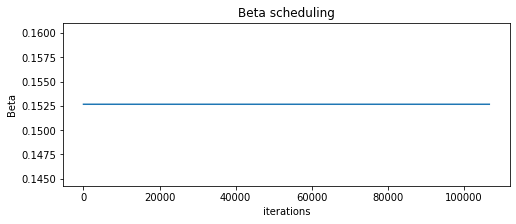

In [28]:
betascheduler_val.summary()

fig = plt.figure(figsize = (8,3))
plt.plot(np.arange(betascheduler_train.n_iter), betascheduler_train.schedule[:-1])
plt.title('Beta scheduling')
plt.xlabel('iterations')
plt.ylabel('Beta')
plt.show()
fig.savefig(os.path.join(ROOT,'model_KDDCUP99','VAE','betascheduler_anomaly.png'))

In [57]:
hidden_dim = best_params['hidden_dim']
hidden_channel = best_params['hidden_channels']
latent_dim = best_params['latent_dim']

enc = Vae_Encoder(121,hidden_dim,latent_dim,hidden_channel)
dec = Vae_Decoder(121,hidden_dim,latent_dim,hidden_channel)


In [62]:
hidden_channel

1

In [68]:
from torchsummary import summary

summary(vae,(121,),)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       Vae_Decoder-1                  [-1, 121]               0


AttributeError: 'int' object has no attribute 'numpy'

In [14]:
# load mode tpl
LOAD_MODEL = True

if LOAD_MODEL:
    checkpoint = torch.load(os.path.join(ROOT,'model_KDDCUP99','VAE','vae_model.pt'))
    vae.load_state_dict(checkpoint['model_state_dict'])
    vae_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    vae_epoch = checkpoint['epoch']
    vae_loss = checkpoint['loss']

In [39]:
vae_statistics = vae_training_loop(vae_num_epochs, vae_optimizer, vae_scheduler, vae, train_dataloader,
                                    val_dataloader, betascheduler_train, betascheduler_val, strategy1 = best_params['strategy'], criterion = criterion )



Epoch: 1  Lr: 0.00099946  Loss: Train = [1388.9893] - Val = [649.3065]  KLD: Train = [571.3902] - Val = [370.1901]  REC: Train = [1536.5276] - Val = [699.6117]  Time one epoch (s): 6.2450 
Epoch: 2  Lr: 0.00099946  Loss: Train = [498.6226] - Val = [419.5410]  KLD: Train = [457.2508] - Val = [480.3228]  REC: Train = [506.0764] - Val = [408.5903]  Time one epoch (s): 2.9466 
Epoch: 3  Lr: 0.00099946  Loss: Train = [401.6739] - Val = [364.3573]  KLD: Train = [513.1655] - Val = [515.3574]  REC: Train = [381.5871] - Val = [337.1525]  Time one epoch (s): 3.0180 
Epoch: 4  Lr: 0.00099946  Loss: Train = [360.6755] - Val = [327.6883]  KLD: Train = [529.0588] - Val = [526.4820]  REC: Train = [330.3389] - Val = [291.8729]  Time one epoch (s): 2.8983 
Epoch: 5  Lr: 0.00099946  Loss: Train = [332.0276] - Val = [304.9869]  KLD: Train = [512.9479] - Val = [511.6653]  REC: Train = [299.4322] - Val = [267.7509]  Time one epoch (s): 2.8534 
Epoch: 6  Lr: 0.00099946  Loss: Train = [311.4769] - Val = [289

In [40]:
best_epoch_loss_vae = np.argmin(vae_statistics['loss_mae_val']) + 1
best_loss_vae = vae_statistics['loss_mae_val'][best_epoch_loss_vae - 1]

print(f'Best val mae: {best_loss_vae: .5f} epoch: {best_epoch_loss_vae}')

Best val mae:  0.00182 epoch: 172


In [68]:
# Save the model

EPOCH = best_epoch_loss_vae
CHECKPOINT_ROOT = os.path.join(ROOT,'model_KDDCUP99')
LOSS = best_loss_vae

if not os.path.exists(CHECKPOINT_ROOT):
    os.makedirs(CHECKPOINT_ROOT)

torch.save({
            'epoch': EPOCH,
            'model_state_dict':vae.state_dict(),
            'optimizer_state_dict': vae_optimizer.state_dict(),
            'scheduler_state_dict': vae_scheduler.state_dict(),
            'loss': LOSS,
            }, os.path.join(CHECKPOINT_ROOT,'VAE','vae_model.pt'))

In [69]:
vae_statistics['loss_mae_val'] = list(np.array(vae_statistics['loss_mae_val']).reshape(-1))
vae_statistics['loss_mae_train'] = list(np.array(vae_statistics['loss_mae_train']).reshape(-1))

In [70]:
for k in vae_statistics.keys():
    try:
        vae_statistics[k] = [float(el) for el in vae_statistics[k]]
    except:
        pass

In [71]:
with open(os.path.join(CHECKPOINT_ROOT,'VAE','model_stats.json'), 'w+') as f:
    json.dump(vae_statistics, f)

In [71]:
with open(os.path.join(ROOT,'model_KDDCUP99','VAE','best_param.json'), 'w+') as f:
    json.dump(best_trial.params,f)

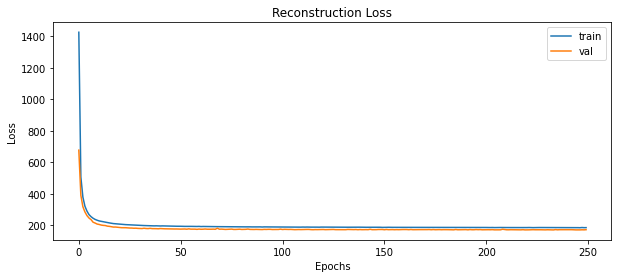

In [73]:
fig = plt.figure(figsize =(10,4))
plt.title(f'Reconstruction Loss' )
plt.plot(np.arange(vae_num_epochs),vae_statistics['loss_rec_train'], label = 'train')
plt.plot(np.arange(vae_num_epochs), vae_statistics['loss_rec_val'] ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT,'VAE','rec_loss.png'))


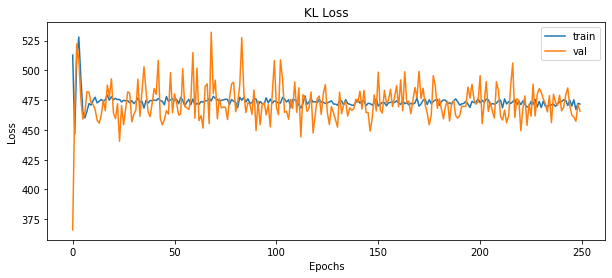

In [74]:
fig = plt.figure(figsize =(10,4))

plt.title(f'KL Loss')
plt.plot(np.arange(vae_num_epochs), np.array(vae_statistics['loss_kld_train']), label = 'train')
plt.plot(np.arange(vae_num_epochs), np.array(vae_statistics['loss_kld_val']) ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT,'VAE','kl_loss.png'))

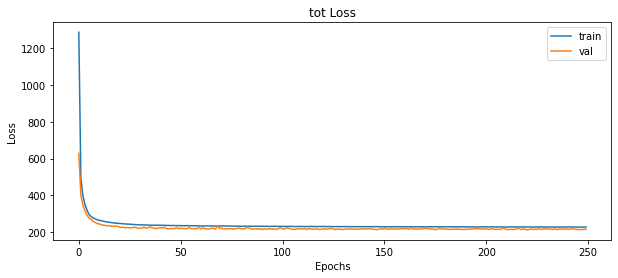

In [75]:
fig = plt.figure(figsize =(10,4))

plt.title(f'tot Loss')
plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_values_train']), label = 'train')
plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_values_val']) ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT,'VAE','tot_loss.png'))

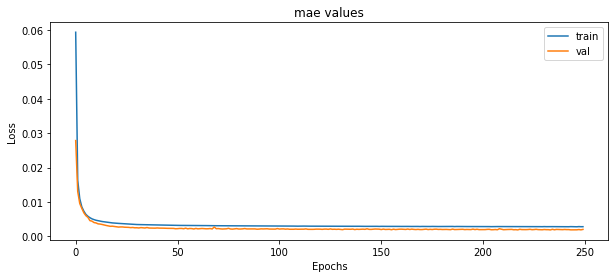

In [76]:
fig = plt.figure(figsize =(10,4))

plt.title(f'mae values')

plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_mae_train']), label = 'train')
plt.plot(np.arange(vae_num_epochs),np.array(vae_statistics['loss_mae_val']) ,label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig(os.path.join(CHECKPOINT_ROOT,'VAE','mae_values.png'))

In [41]:
train_res, train_res_enc = compute_prediction(vae,train_dataset, has_real = False)
train_res = np.array([el.numpy() for el in train_res]).squeeze(1)

In [42]:
train_mae_vector = get_error_term(train_res, X_train, _rmse=False)
print(
    f'Avg error {np.mean(train_mae_vector)}\nmedian error {np.median(train_mae_vector)}\n99Q: {np.quantile(train_mae_vector, 0.99)}')
print(f'setting threshold on {np.quantile(train_mae_vector, 0.99)} ')
error_thresh = np.quantile(train_mae_vector, 0.99)
train_anomalies = (train_mae_vector > error_thresh)

Avg error 0.0018768198031455195
median error 0.0014050010336230036
99Q: 0.00954480767497776
setting threshold on 0.00954480767497776 


In [44]:
val_res, val_res_enc = compute_prediction(vae,val_dataset, has_real = False)
val_res = np.array([el.numpy() for el  in val_res]).squeeze(1) # np.array([el.rsample().numpy() for el  in val_res]).squeeze(1)
val_mae_vector = get_error_term(val_res, X_val, _rmse=False)
val_anomalies = (val_mae_vector > error_thresh)

np.count_nonzero(val_anomalies) / len(val_anomalies)

0.011093502377179081

In [80]:
val_encoded = np.array([d.loc.numpy() for d in val_res_enc]).squeeze(1)

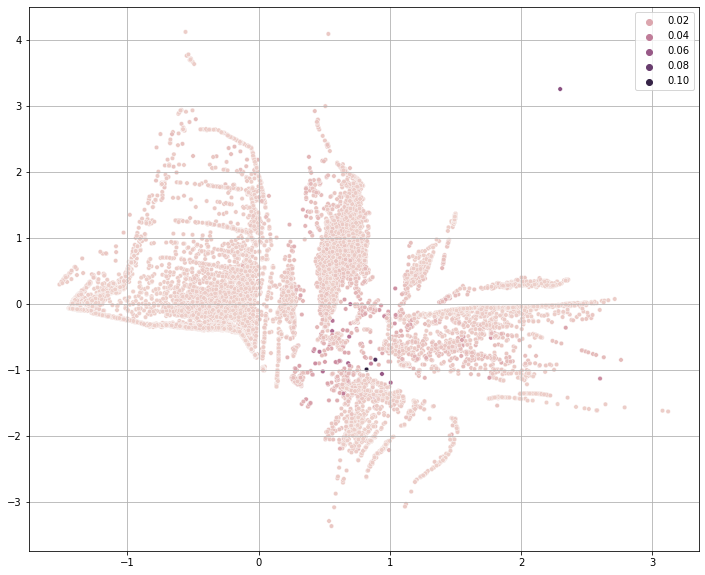

In [90]:
pca = PCA(n_components=2)
pca = pca.fit(val_encoded)
X_transform = pca.transform(val_encoded)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=val_mae_vector)
plt.grid()
plt.show()

In [18]:
val_res, val_res_enc = compute_prediction(vae,val_dataset, has_real = False)
val_res = np.array([el.numpy() for el  in val_res]).squeeze(1) # np.array([el.rsample().numpy() for el  in val_res]).squeeze(1)
test_res, test_res_enc = compute_prediction(vae,test_dataset, has_real = False)
test_res = np.array([el.numpy() for el  in test_res]).squeeze(1) # np.array([el.rsample().numpy() for el  in val_res]).squeeze(1)

In [96]:
test_res, test_res_enc = compute_prediction(vae,test_dataset, has_real = False)
test_res = np.array([el.numpy() for el  in test_res]).squeeze(1) # np.array([el.rsample().numpy() for el  in val_res]).squeeze(1)
mae_vector = get_error_term(test_res, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.4640984786184211

In [89]:
test_encoded = np.array([d.loc.numpy() for d in test_res_enc]).squeeze(1)
X_transform_test = pca.transform(test_encoded)
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform_test[:, 0], y=X_transform_test[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

NameError: name 'pca' is not defined

In [90]:
train_mae_vae =  pd.DataFrame(np.abs(train_res - X_train ))
val_mae_vae = pd.DataFrame(np.abs(val_res - X_val))
test_mae_vae = pd.DataFrame(np.abs(test_res - X_test ))

train_prob_vae = np.where(train_mae_vae > train_mae_vae.quantile(0.99, axis = 0),1,0).mean(axis = 1)
train_pred_anomalies_vae = np.where(train_prob_vae >0.05, True, False)
print(f'\n classification report \n {classification_report(np.zeros(len(train_pred_anomalies_vae)), train_pred_anomalies_vae)}')


c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 classification report 
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     54475
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96     54475
   macro avg       0.50      0.48      0.49     54475
weighted avg       1.00      0.96      0.98     54475



c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
#val_prob_vae = np.where(val_mae_vae > train_mae_vae.quantile(0.99, axis=0), 1, 0).mean(axis=1)
#val_pred_anomalies_vae = np.where(val_prob_vae > 0.05, True, False)

val_pred_anomalies_vae = (val_mae_vae.mean(axis = 1) > error_thresh)
print(
    f'\n classification report \n {classification_report(np.zeros(len(val_pred_anomalies_vae)), val_pred_anomalies_vae)}')


 classification report 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     23347
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99     23347
   macro avg       0.50      0.49      0.50     23347
weighted avg       1.00      0.99      0.99     23347



c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [99]:
contingency_matrix(np.zeros(len(val_pred_anomalies_vae)), val_pred_anomalies_vae)

array([[23088,   259]], dtype=int64)

In [125]:
test_prob_vae

array([0.01652893, 0.00826446, 0.01652893, ..., 0.65289256, 0.6446281 ,
       0.65289256])

In [127]:
#test_prob_vae = np.where(test_mae_vae > train_mae_vae.quantile(0.99, axis=0), 1, 0).mean(axis=1)
#test_pred_anomalies_vae = np.where(test_prob_vae > 0.05, True, False)
test_pred_anomalies_vae = (test_mae_vae.mean(axis = 1) > error_thresh)

print(f'\n classification report \n {classification_report(y_test, test_pred_anomalies_vae)}')


 classification report 
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     19456
         1.0       0.97      0.90      0.94     19456

    accuracy                           0.94     38912
   macro avg       0.94      0.94      0.94     38912
weighted avg       0.94      0.94      0.94     38912



In [102]:
len(y_test)

38912

In [101]:
contingency_matrix(y_test, test_pred_anomalies_vae)

array([[19002,   454],
       [ 1851, 17605]], dtype=int64)

PCA REC

In [105]:
def pca_reconstruct(dataset: np.ndarray,
                    pca_model: PCA):
    '''
    :param dataset: input dataset
    :param pca_model: pca model already fitted on X_train
    :return: per sample reconstruction error, dataset reconstructed
    '''

    dataset_transformed = pca_model.transform(dataset)
    dataset_reconstructed = pca_model.inverse_transform(dataset_transformed)
    rec_error = (np.abs(dataset - dataset_reconstructed)).mean(axis = 1)
    return rec_error, dataset_reconstructed


In [106]:
def objective_PCA(trial,dataset_train,dataset_val):

    params = {'n_comp': trial.suggest_int('n_comp', 1,120)}
    pca = PCA(n_components = params['n_comp'])
    pca = pca.fit(dataset_train)
    mean_mae,_ = pca_reconstruct(dataset_val,pca)
    return np.mean(mean_mae)


In [107]:
X_train_unscaled = scaler.inverse_transform(X_train)
X_val_unscaled = scaler.inverse_transform(X_val)
X_test_unscaled = scaler.inverse_transform(X_test)

In [108]:
std_scaler = StandardScaler()

In [109]:
X_train_standardized = std_scaler.fit_transform(X_train_unscaled)
X_val_standardized = std_scaler.transform(X_val_unscaled)
X_test_standardized = std_scaler.transform(X_test_unscaled)

In [107]:
mean_mae_val_list = []
mean_mae_train_list = []
for el in tqdm(range(121)):
    pca = PCA(n_components = el)
    pca = pca.fit(X_train_standardized)
    mean_mae_train,_ = pca_reconstruct(X_train_standardized,pca)
    mean_mae_val,_ = pca_reconstruct(X_val_standardized,pca)
    mean_mae_train_list.append(np.mean(mean_mae_train))
    mean_mae_val_list.append(np.mean(mean_mae_val))


100%|██████████| 121/121 [05:25<00:00,  2.69s/it]


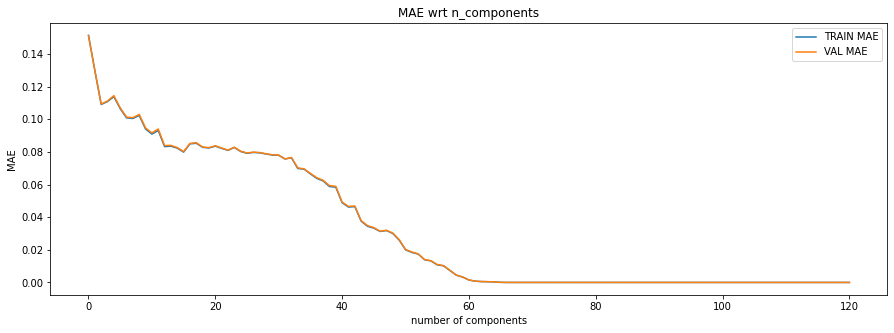

In [111]:
fig = plt.figure(figsize =(15,5))
plt.plot(np.arange(121),mean_mae_train_list, label = 'TRAIN MAE')
plt.plot(np.arange(121),mean_mae_val_list, label = 'VAL MAE')
plt.title('MAE wrt n_components')
plt.xlabel('number of components')
plt.ylabel('MAE')
plt.legend()
plt.show()

fig.savefig(os.path.join(ROOT,'model_KDDCUP99','PCA','mae_values.png'))

In [184]:
#study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
#obj = partial(objective_PCA, dataset_train = X_train_standardized, dataset_val = X_val_standardized )
#study.optimize(obj, n_trials=30)

[I 2022-08-10 16:08:06,267] A new study created in memory with name: no-name-6a821855-a4fe-4062-abc9-60ebb980017b
[I 2022-08-10 16:08:10,608] Trial 0 finished with value: 4.915854783753662e-07 and parameters: {'n_comp': 117}. Best is trial 0 with value: 4.915854783753662e-07.
[I 2022-08-10 16:08:14,889] Trial 1 finished with value: 2.2869107384755246e-06 and parameters: {'n_comp': 86}. Best is trial 0 with value: 4.915854783753662e-07.
[I 2022-08-10 16:08:15,963] Trial 2 finished with value: 0.079972572263017 and parameters: {'n_comp': 14}. Best is trial 0 with value: 4.915854783753662e-07.
[I 2022-08-10 16:08:17,898] Trial 3 finished with value: 0.0491952595716736 and parameters: {'n_comp': 40}. Best is trial 0 with value: 4.915854783753662e-07.
[I 2022-08-10 16:08:19,366] Trial 4 finished with value: 0.07531647628411167 and parameters: {'n_comp': 31}. Best is trial 0 with value: 4.915854783753662e-07.
[I 2022-08-10 16:08:21,229] Trial 5 finished with value: 0.03358990383581169 and pa

In [110]:
pca = PCA(n_components=60)
pca = pca.fit(X_train_standardized)

train_rec_err,train_rec = pca_reconstruct(X_train_standardized,pca)
val_rec_err,val_rec = pca_reconstruct(X_val_standardized,pca)
test_rec_err,test_rec = pca_reconstruct(X_test_standardized,pca)

In [111]:
print(f'Train error: {np.mean(train_rec_err)} \n '
      f'Val error: {np.mean(val_rec_err)} \n'
      f'Test error : {np.mean(test_rec_err)}')

Train error: 0.0014813990382603077 
 Val error: 0.001541788942696551 
Test error : 0.010528398654611774


In [112]:
print(f'Test normal samples error: {np.mean(test_rec_err[y_test == 1])} \n'
      f'Test anomalies samples error:{np.mean(test_rec_err[y_test == 0])}')

Test normal samples error: 0.018411678178723512 
Test anomalies samples error:0.0026451191305000396


In [113]:
print(
    f'Avg error {np.mean(train_rec_err)}\nmedian error {np.median(train_rec_err)}\n99Q: {np.quantile(train_rec_err, 0.99)}')
print(f'setting threshold on {np.quantile(train_rec_err, 0.99)} ')
error_thresh_pca = np.quantile(train_rec_err, 0.99)
train_anomalies_pca = (train_rec_err > error_thresh_pca)

Avg error 0.0014813990382603077
median error 0.0003175656503451548
99Q: 0.021479577583777876
setting threshold on 0.021479577583777876 


In [114]:
train_mae_pca = pd.DataFrame(np.abs(train_rec - X_train_standardized ))
val_mae_pca = pd.DataFrame(np.abs(val_rec - X_val_standardized ))
test_mae_pca = pd.DataFrame(np.abs(test_rec - X_test_standardized ))

train_prob = np.where(train_mae_pca > train_mae_pca.quantile(0.99, axis = 0),1,0).mean(axis = 1)
train_pred_anomalies_pca = np.where(train_prob > 0.05, True, False)
print(f'\n classification report \n {classification_report(np.zeros(len(train_pred_anomalies_pca)), train_pred_anomalies_pca)}')


c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 classification report 
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     54475
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96     54475
   macro avg       0.50      0.48      0.49     54475
weighted avg       1.00      0.96      0.98     54475



c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
val_prob = np.where(val_mae_pca > train_mae_pca.quantile(0.99, axis = 0),1,0).mean(axis = 1)
val_pred_anomalies_pca = np.where(val_prob > 0.05, True, False)
print(f'\n classification report \n {classification_report(np.zeros(len(val_pred_anomalies_pca)), val_pred_anomalies_pca)}')


 classification report 
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     23347
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96     23347
   macro avg       0.50      0.48      0.49     23347
weighted avg       1.00      0.96      0.98     23347



c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
contingency_matrix(np.zeros(len(val_pred_anomalies_pca)), val_pred_anomalies_pca)

array([[22439,   908]], dtype=int64)

In [117]:
test_prob = np.where(test_mae_pca > train_mae_pca.quantile(0.99, axis = 0),1,0).mean(axis = 1)
test_pred_anomalies_pca = np.where(test_prob > 0.05, True, False)
print(f'\n classification report \n {classification_report(y_test, test_pred_anomalies_pca)}')


 classification report 
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.89     19456
         1.0       0.88      0.89      0.89     19456

    accuracy                           0.89     38912
   macro avg       0.89      0.89      0.89     38912
weighted avg       0.89      0.89      0.89     38912



In [118]:
contingency_matrix(y_test, test_pred_anomalies_pca)

array([[17173,  2283],
       [ 2077, 17379]], dtype=int64)

In [120]:
val_anomalies_pca = (val_rec_err > error_thresh_pca)
np.count_nonzero(val_anomalies_pca) / len(val_anomalies_pca)

0.011478990876772177

In [121]:
print(classification_report(np.zeros(len(val_anomalies_pca)), val_anomalies_pca))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     23347
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99     23347
   macro avg       0.50      0.49      0.50     23347
weighted avg       1.00      0.99      0.99     23347



c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\39320\netlov\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
test_anomalies_pca = (test_rec_err > error_thresh_pca)
np.count_nonzero(test_anomalies_pca) / len(test_anomalies_pca)

0.16105571546052633

In [213]:
test_anomalies_pca

array([False, False, False, ...,  True,  True,  True])

In [123]:
print(classification_report(y_test, test_anomalies_pca))

              precision    recall  f1-score   support

         0.0       0.59      0.98      0.73     19456
         1.0       0.94      0.30      0.46     19456

    accuracy                           0.64     38912
   macro avg       0.76      0.64      0.60     38912
weighted avg       0.76      0.64      0.60     38912



aggregated 1d- hypothesis test with Bonferroni/FDR Correction

In [252]:
def aggregated_1d(d1: Union[pd.DataFrame, np.ndarray],
                  d2 : Union[pd.DataFrame, np.ndarray],
                  alpha:int = 0.05,
                  correction: Union[str, type(None)] = 'bonferroni'):
    '''

    :param d1: Reference Dataset
    :param d2: Comparison Dataset
    :param alpha: alpha values for single tests
    :param correction: the type of corecction
    :return: the aggregated results nd the suingles p_values

    '''

    if d1.shape[1] != d2.shape[1]:
        print('Number of features must be the same!')
    else:
        res = []
        for el in range(d1.shape[1]):
            res.append(scipy.stats.ks_2samp(d1[:,el],d2[:,el]))
        pvalues = [el.pvalue for el in res]
        corrected_result = multipletests(pvalues, alpha = alpha, method = correction)
        return  corrected_result, res

In [47]:
def compute_daily_1d(dataset:pd.DataFrame,
                     reference_dataset: pd.DataFrame,
                     test: str) -> pd.DataFrame:
    res_test = dataset.drop(columns = ['id', DATA_COL]).apply(lambda y :compute_1d_test(y,reference_dataset,test))
    if test == 'psi':
        res = np.where(res_test > 0.2, 1,0).mean(axis = 0)
    elif test == 'ks':
        res = np.where(res_test < 0.01, 1,0).mean(axis = 0)
        #res = np.mean(multipletests(res_test, alpha = 0.5)[0])
    else:
        print('Insert a valid test, ks - psi')
        return
    return res
def compute_1d_test(reference_col: Union[pd.Series, np.ndarray],
                    current_df : Union[pd.DataFrame, np.ndarray],
                    test:str = 'ks'):
    '''
    :param reference_col: column in reference dataset
    :param current_col: DataFrame in current day/period
    :param test: ks - psi - chisq
    :return: pvalue/statistics of the test
    '''
    current_col = current_df[reference_col.name]
    start = min(min(current_col),min(reference_col))
    stop = max(max(current_col),max(reference_col))
    bins = np.linspace(start, stop, 100)

    ref_freq, _ = np.histogram(reference_col, bins = bins, density = True)
    curr_freq, _ = np.histogram(current_col, bins = bins, density = True)

    if test == 'ks':
        res = scipy.stats.ks_2samp(ref_freq, curr_freq).pvalue

    elif test == 'psi':
        # PSI < 0.1 no change - PSI >=0.1 moderate PDI > 0.2 - high
        res = psi.calculate_psi(ref_freq, ref_freq)
    elif test == 'chisq':
        res = scipy.stats.chisquare(ref_freq, curr_freq).pvalue
    else:
        print('Specify a valis test: ks - psi - chisq')

    return res



In [50]:
pd.DataFrame(X_val)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,4.586259e-07,0.000627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,4.932391e-07,0.000063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,3.778616e-07,0.000035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,4.773747e-07,0.000724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342,0.0,2.884439e-07,0.000096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
23343,0.0,2.267458e-05,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
23344,0.0,6.922655e-08,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
23345,0.0,2.509462e-07,0.000086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [73]:
ks_val = pd.DataFrame(X_val).apply(lambda y :compute_1d_test(y,pd.DataFrame(X_train),'ks'))
ks_perc_val = np.where(ks_val < 0.05, True,False).mean(axis = 0)
if ks_perc_val > 0:
    print(f'''percetunale di dimensioni drifttate:{round(ks_perc_val,4)*100}% ''')
    print('different dimension:')
    for el in ks_val.index[[np.where(ks_val < 0.05, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

percetunale di dimensioni drifttate:0.01652892561983471 
different dimension:
30
32


c:\users\39320\netlov\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [83]:
psi_val = pd.DataFrame(X_val).apply(lambda y :compute_1d_test(y,pd.DataFrame(X_train),'psi'))
psi_perc_val = np.where(psi_val > 0.2, True,False).mean(axis = 0)
if psi_perc_val > 0:
    print(f'''percetunale di dimensioni drifttate:{round(psi_perc_val,4)*100}% ''')
    print('different dimension:')
    for el in psi_val.index[[np.where(psi_val > 0.2, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


 Nessuna dimensione driftata


In [74]:
ks_test = pd.DataFrame(X_test).apply(lambda y :compute_1d_test(y,pd.DataFrame(X_train),'ks'))
ks_perc_test = np.where(ks_test < 0.05, True,False).mean(axis = 0)
if ks_perc_test > 0:
    print(f'''percetunale di dimensioni drifttate:{ks_perc_test} ''')
    print('different dimension:')
    for el in ks_val.index[[np.where(ks_test < 0.05, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


percetunale di dimensioni drifttate:0.1322314049586777 
different dimension:
0
15
16
17
19
21
23
24
25
26
27
28
30
31
32
33


c:\users\39320\netlov\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [81]:
psi_test = pd.DataFrame(X_test).apply(lambda y :compute_1d_test(y,pd.DataFrame(X_train),'psi'))
psi_perc_test = np.where(psi_test > 0.2, True,False).mean(axis = 0)
if psi_perc_test > 0:
    print(f'''percetunale di dimensioni drifttate:{psi_perc_test} ''')
    print('different dimension:')
    for el in psi_test.index[[np.where(psi_test > 0.2, True,False)]]:
        print(el)
else:
    print(' Nessuna dimensione driftata')

c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
c:\users\39320\netlov\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


 Nessuna dimensione driftata


In [277]:
print(f'corrected alpha for Sidak method: {corrected_res_val[2]} \n'
      f'corrected alpha for Bonferroni method: {corrected_res_val[3]} \n'
      f'Result: ')
pd.DataFrame([np.array([el.pvalue for el in res_val]),corrected_res_val[1],corrected_res_val[0]])

corrected alpha for Sidak method: 0.0004238216860689148 
corrected alpha for Bonferroni method: 0.0004132231404958678 
Result: 


,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.99163,0.475375,0.805167,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [268]:
corrected_res_test, res_test = aggregated_1d(X_train,X_test)

In [278]:
print(f'corrected alpha for Sidak method: {corrected_res_test[2]} \n'
      f'corrected alpha for Bonferroni method: {corrected_res_test[3]} \n'
      f'Result: ')
pd.DataFrame([np.array([el.pvalue for el in res_test]),corrected_res_test[1],corrected_res_test[0]])

corrected alpha for Sidak method: 0.0004238216860689148 
corrected alpha for Bonferroni method: 0.0004132231404958678 
Result: 


,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,0.0,0.0,0.983302,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.997203,1.0,1.0,0.0,0.0,1.0,0.999868,0.999868
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2,True,True,True,False,False,True,False,True,False,False,...,False,True,False,False,False,True,True,False,False,False
